# ANN with/without GPU

we will consider **2 hidden layer** and train the MNIST/FashionMNIST dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from torchvision.datasets import MNIST, FashionMNIST
from torchvision.utils import make_grid

from torch.utils import data 


In [2]:
train_data = FashionMNIST( root = '~/Developer/PyTorch_YouTube/DATA/', download=True, 
                   transform=transforms.ToTensor(), train=True)

test_data = FashionMNIST( root = '~/Developer/PyTorch_YouTube/DATA/', download=True, 
                   transform=transforms.ToTensor(), train=False)
print('Length of Training Data = ', len(train_data))
print('Length of Testing Data = ', len(test_data))

Length of Training Data =  60000
Length of Testing Data =  10000


# Initilize

In [3]:
batch_size = 64

val_size = 10000 # val_size = 10000, train_size = 50000
train_size = len(train_data) - val_size

### Converting 'train_data' into 'validation' and 'training' dataset

In [4]:
train_data, val_data = data.random_split(train_data, [train_size, val_size])

len(train_data), len(val_data)

(50000, 10000)

**num_workers** and **pin_memory**

In [5]:
train_batch = data.DataLoader(dataset= train_data, batch_size=batch_size, shuffle= True, num_workers=4, pin_memory=True) # Parellization = 4, pin_memory

val_batch = data.DataLoader(dataset= val_data, batch_size=batch_size, num_workers=4, pin_memory=True)

In [6]:
for img, _ in train_batch:
    print('img shape =', img.shape)
    print('Permute =', img.permute(2,3,1,0).shape)
    break

img shape = torch.Size([64, 1, 28, 28])
Permute = torch.Size([28, 28, 1, 64])


### permute(1,2,0):
The function changes the dimensions\
0th position value is placed in last position and so on

img.shape = torch.Size([64, 1, 28, 28])
torch.Size([3, 212, 302])


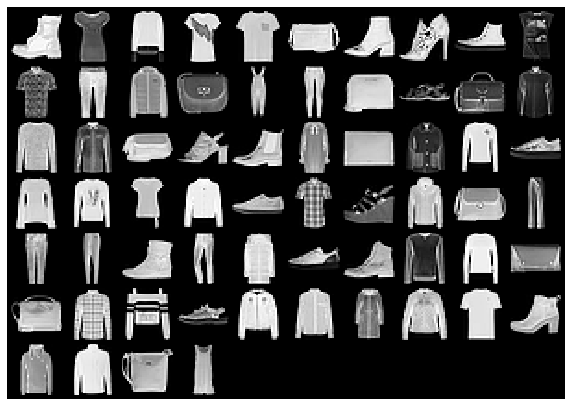

In [7]:
for img, _ in train_batch:
    print('img.shape =', img.shape)
    plt.figure(figsize=(10,10))
    plt.axis('off')
    print(make_grid(img, nrow=10).shape)
    plt.imshow(make_grid(img, nrow=10).permute(1,2,0))
    # permute used to change the dim of the data
    break

In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    acc = torch.tensor(torch.sum(preds == labels).item()/len(preds))
    return acc

## Build Model with Training and Validation

In [9]:
# INITILIZE

img_size = 28*28

hidden_size = 128

n_class = 10


In [10]:
class NeuralNet(nn.Module):
    """Feed Forward Neural Network with 1 hidden Layer"""
    def __init__(self, img_size, hidden_size, n_class):
        super().__init__()
        self.FC1 = nn.Linear(img_size, hidden_size)
        self.FC2 = nn.Linear(hidden_size, hidden_size)
        self.FC3 = nn.Linear(hidden_size, n_class)
        
    def forward(self, img):
        #flatten the image
        flat_img = img.reshape(-1, img_size)
        
        layer1 = self.FC1(flat_img)
        # apply activation Layer
        activation1 = F.relu(layer1)
        
        layer2 = self.FC2(activation1)
        activation2 = F.relu(layer2)
        
        out = self.FC3(activation2)
        
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)   # it calls forward(img) function
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, label = batch
        out = self(images)
        loss = F.cross_entropy(out, label)
        acc = accuracy(out, label)
        #print(acc)
        return {'Validation_Loss =': loss.detach(), 'Validation_Acc =': acc.detach()}
    
    def validation_epoch_end(self, output):
        batch_loss = [x['Validation_Loss ='] for x in output]
        epoch_loss = torch.stack(batch_loss).mean()
        #print(epoch_loss)
        batch_acc = [x['Validation_Acc ='] for x in output]
        #print(batch_acc)
        epoch_acc = torch.stack(batch_acc).mean()
        #print(epoch_acc)
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        

In [11]:
model = NeuralNet(img_size, hidden_size, n_class)


# Train the Model

Take 1st Batch (100 images) and pass through the model

In [12]:
for images, labels in train_batch:
    output = model(images)
    loss = F.cross_entropy(output, labels)
    print(loss.item())
    loss.backward()
    print(loss.item())
    break
    

2.2988483905792236
2.2988483905792236


In [13]:
for i in model.parameters():
    print(i.shape)

torch.Size([128, 784])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])


# Check GPU or CPU
Implement a helper function to ensure code uses GPU or CPU


In [14]:
def get_default_devices():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [15]:
device = get_default_devices()
device # it is an object

device(type='cpu')

## Define a function that moves Data to chosen Model

In [16]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [17]:
for images, labels in train_data:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([1, 28, 28])
cpu


### Move data to Devices
**YIELD**\
when we call the function, the code we have written in the function body does not run. The function only returns the generator object, this is a bit tricky :-)

Then, your code will continue from where it left off each time for uses the generator.

Here "device" is an generator Object

In [18]:
class DeviceDataLoader():
    """wrap a dataloader to moe data to devices"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    

**We wrap our training data using "DeviceDataLoader"**

In [19]:
train_loader = DeviceDataLoader(train_batch, device)
val_loader = DeviceDataLoader(val_batch, device)
val_loader

In [20]:
for img, label in val_loader:
    print('x device: ', img.device)
    print('y: ', label)
    break

x device:  cpu
y:  tensor([6, 1, 2, 9, 0, 4, 4, 4, 2, 5, 9, 5, 4, 5, 1, 8, 8, 2, 1, 4, 2, 1, 7, 5,
        2, 0, 2, 2, 1, 9, 1, 9, 4, 6, 3, 1, 0, 5, 8, 9, 9, 1, 5, 2, 0, 5, 8, 4,
        3, 4, 2, 0, 7, 8, 3, 2, 0, 9, 3, 1, 0, 0, 1, 8])


# Train the Model in Loop

In [21]:
def evaluate(model, val_loader):
    output = [model.validation_step(batch) for batch in val_loader]
    #print(output)
    return model.validation_epoch_end(output)

def fit(epoch, lr, model, train_loader, val_loader, opt_fun = torch.optim.SGD):
    history=[]
    opti = opt_fun(model.parameters(), lr)
    for epoch in range(epoch):
        #training phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            opti.step()
            opti.zero_grad()
        
        #validation Step
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [22]:
# Model (on GPU)
model = NeuralNet(img_size, hidden_size=hidden_size, n_class=n_class)
to_device(model, device)

NeuralNet(
  (FC1): Linear(in_features=784, out_features=128, bias=True)
  (FC2): Linear(in_features=128, out_features=128, bias=True)
  (FC3): Linear(in_features=128, out_features=10, bias=True)
)

In [23]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.302544355392456, 'val_acc': 0.10230891406536102}]

In [24]:
history += fit(5, 0.5, model, train_loader, val_loader)


Epoch [0], val_loss: 0.5764, val_acc: 0.8020
Epoch [1], val_loss: 0.6182, val_acc: 0.7946
Epoch [2], val_loss: 0.5447, val_acc: 0.8123
Epoch [3], val_loss: 0.4992, val_acc: 0.8184
Epoch [4], val_loss: 0.4081, val_acc: 0.8466


In [25]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3536, val_acc: 0.8712
Epoch [1], val_loss: 0.3242, val_acc: 0.8817
Epoch [2], val_loss: 0.3301, val_acc: 0.8801
Epoch [3], val_loss: 0.3396, val_acc: 0.8743
Epoch [4], val_loss: 0.3148, val_acc: 0.8838


In [26]:
history += fit(5, 0.0001, model, train_loader, val_loader)
history

Epoch [0], val_loss: 0.3139, val_acc: 0.8842
Epoch [1], val_loss: 0.3132, val_acc: 0.8834
Epoch [2], val_loss: 0.3127, val_acc: 0.8837
Epoch [3], val_loss: 0.3123, val_acc: 0.8833
Epoch [4], val_loss: 0.3120, val_acc: 0.8834


[{'val_loss': 2.302544355392456, 'val_acc': 0.10230891406536102},
 {'val_loss': 0.5764158964157104, 'val_acc': 0.8019506335258484},
 {'val_loss': 0.6181585192680359, 'val_acc': 0.7945860028266907},
 {'val_loss': 0.5447341799736023, 'val_acc': 0.812300980091095},
 {'val_loss': 0.49915969371795654, 'val_acc': 0.8183718323707581},
 {'val_loss': 0.4081467092037201, 'val_acc': 0.846636176109314},
 {'val_loss': 0.3535965085029602, 'val_acc': 0.8712181448936462},
 {'val_loss': 0.324203222990036, 'val_acc': 0.881667971611023},
 {'val_loss': 0.330051451921463, 'val_acc': 0.8800756335258484},
 {'val_loss': 0.3395563066005707, 'val_acc': 0.8743033409118652},
 {'val_loss': 0.31481751799583435, 'val_acc': 0.8837579488754272},
 {'val_loss': 0.31391048431396484, 'val_acc': 0.8841560482978821},
 {'val_loss': 0.31321993470191956, 'val_acc': 0.8833598494529724},
 {'val_loss': 0.31269338726997375, 'val_acc': 0.8836584687232971},
 {'val_loss': 0.3122977018356323, 'val_acc': 0.8832603693008423},
 {'val_los

# Plot the data

Text(0.5, 1.0, 'Loss vs. No. of epochs')

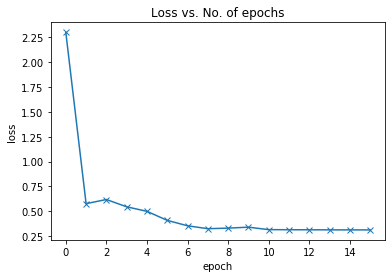

In [27]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs')

Accurracy = 88.34


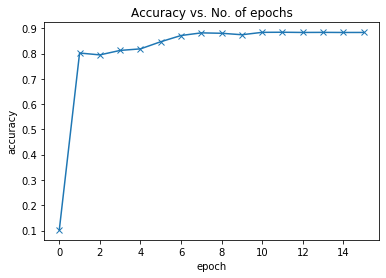

In [28]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')
print('Accurracy = {:.2f}'.format(accuracies[-1]*100))